[Open in Google Colab](https://colab.research.google.com/github/pachterlab/kb_docs/blob/main/docs/source/sc/notebooks/seurat.ipynb)

# Introduction to single-cell RNA-seq: Seurat (R)

This notebook demonstrates pre-processing and basic analysis of the 1k Human PBMCs (https://www.10xgenomics.com/datasets/1-k-human-pbm-cs-stained-with-a-panel-of-total-seq-b-antibodies-single-indexed-3-1-standard-4-0-0) dataset from 10x genomics. Following pre-processing using kallisto and bustools and basic QC, the notebook demonstrates some initial analysis. The approximate running time of the notebook (excluding Seurat installation) is about 15 minutes.

The notebook was written by Joseph Rich and Lior Pachter, based off an older version written by Kyung Hoi (Joseph) Min, Lambda Moses, A. Sina Booeshaghi and Lior Pachter. If you use the methods in this notebook for your analysis please cite the following publications which describe the tools used in the notebook, as well as specific methods they run (these are cited inline in the notebook):

* Melsted P, Booeshaghi AS, Liu L, Gao F, Lu L, Min KHJ, et al. Modular, efficient and constant-memory single-cell RNA-seq preprocessing. Nat Biotechnol. 2021 Jul;39(7):813–8.
* Hjörleifsson KE, Sullivan DK, Swarna NP, Holley G, Melsted P, Pachter L. Accurate quantification of single-cell and single-nucleus RNA-seq transcripts using distinguishing flanking k-mers [Internet]. bioRxiv; 2024 [cited 2024 Jul 10]. p. 2022.12.02.518832. Available from: https://www.biorxiv.org/content/10.1101/2022.12.02.518832v3
* Sullivan DK, Min KH (Joseph), Hjörleifsson KE, Luebbert L, Holley G, Moses L, et al. kallisto, bustools, and kb-python for quantifying bulk, single-cell, and single-nucleus RNA-seq [Internet]. BioRxiv; 2023 Nov [cited 2024 Jan 25]. Available from: http://biorxiv.org/lookup/doi/10.1101/2023.11.21.568164

See the [kb-python tutorials](https://kallisto.readthedocs.io/en/latest/) site for additional notebooks demonstrating other analyses.

## Setup

In [1]:
# This is  used to time the running of the notebook
start_time <- Sys.time()

### Install R packages
There are several packages in R built for scRNA-seq data analysis. Here we use Seurat.

In [2]:
system.time({
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
  BiocManager::install(c('multtest', "DropletUtils", "biomaRt"), Ncpus = 2)
  install.packages(c("Seurat", "scico", "ggpointdensity", "hexbin"), Ncpus = 2)
})

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Installing package(s) 'BiocVersion', 'multtest', 'DropletUtils'

also installing the dependencies ‘formatR’, ‘UCSC.utils’, ‘GenomeInfoDbData’, ‘zlibbioc’, ‘matrixStats’, ‘abind’, ‘lambda.r’, ‘futile.options’, ‘statmod’, ‘GenomeInfoDb’, ‘XVector’, ‘MatrixGenerics’, ‘S4Arrays’, ‘futile.logger’, ‘snow’, ‘SparseArray’, ‘sparseMatrixStats’, ‘rhdf5filters’, ‘limma’, ‘locfit’, ‘R.oo’, ‘R.methodsS3’, ‘sitmo’, ‘BiocGenerics’, ‘Biobase’, ‘SingleCellExperiment’, ‘S4Vectors’, ‘IRanges’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘BiocParallel’, ‘DelayedArray’, ‘DelayedMatrixStats’, ‘HDF5Array’, ‘rhdf5’, ‘edgeR’, ‘R.utils’, ‘dqrng’, ‘beachmat’, ‘scuttle’, ‘Rhd

    user   system  elapsed 
3322.496  270.698 2402.259 

In [3]:
library(DropletUtils)
library(Matrix)
library(tidyverse)
library(Seurat)
library(ggpointdensity)
library(scico)
library(scales)
theme_set(theme_bw())

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

In [4]:
# Slightly modified from BUSpaRse, just to avoid installing a few dependencies not used here
read_count_output <- function(dir, name) {
  dir <- normalizePath(dir, mustWork = TRUE)
  m <- readMM(paste0(dir, "/", name, ".mtx"))
  m <- Matrix::t(m)
  m <- as(m, "dgCMatrix")
  # The matrix read has cells in rows
  ge <- ".genes.txt"
  genes <- readLines(file(paste0(dir, "/", name, ge)))
  barcodes <- readLines(file(paste0(dir, "/", name, ".barcodes.txt")))
  colnames(m) <- barcodes
  rownames(m) <- genes
  return(m)
}

### Install kb-python

In [5]:
system("pip3 install kb-python")

In [12]:
getwd()

[1] "/content"

### Download the data

In [6]:
# Download the file using wget
system("wget -q https://cf.10xgenomics.com/samples/cell-exp/4.0.0/SC3_v3_NextGem_SI_PBMC_CSP_1K/SC3_v3_NextGem_SI_PBMC_CSP_1K_fastqs.tar")

# Extract the first tar file
system("tar -xf SC3_v3_NextGem_SI_PBMC_CSP_1K_fastqs.tar")

## Downloading a pre-built index with kb ref

In [7]:
system("kb ref -d human -i index.idx -g t2g.txt")

## Building a custom index with kb ref
See more details in the tutorial on building an index

In [8]:
# # building a standard custom reference from the human genome
# system("kb ref -i index.idx -g t2g.txt -f1 f1.fa human_reference_path.fa human_gtf_path.gtf")

# # building a custom reference from the human genome with k=55 (where k is the size of each k-mer used in pseudoalignment)
# system("kb ref -i index.idx -g t2g.txt -f1 f1.fa -k 55 human_reference_path.fa human_gtf_path.gtf")

# # building a reference with the nac workflow (will detect both splice-aware and unspliced transcripts)
# system("kb ref -i index.idx -g t2g.txt -f1 f1.fa --nac -f2 f2.fa -c1 c1.fa -c2 c2.fa human_reference_path.fa human_gtf_path.gtf")

## Pseudoaligning the scRNA-seq data to the index with kb count

### Run kallisto and bustools

The following command will generate an RNA count matrix of cells (rows) by genes (columns) in .mtx format. Notice that this requires providing the index and transcript-to-gene mapping downloaded in the previous step to the `-i` and `-g` arguments respectively. Also, since the reads were generated with the 10x Genomics Chromium Single Cell v2 Chemistry, the `-x 10xv2` argument is used. To view other supported technologies, run `kb --list`.

In [14]:
# This step runs `kb` to pseudoalign the reads, and then generate the cells x gene matrix in h5ad format.
system("kb count -i index.idx -g t2g.txt -x 10XV3 -t 2 SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_S1_L002_R1_001.fastq.gz SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_S1_L002_R2_001.fastq.gz SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_S1_L003_R1_001.fastq.gz SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_S1_L003_R2_001.fastq.gz SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_S1_L004_R1_001.fastq.gz SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_S1_L004_R2_001.fastq.gz")

In [15]:
list.files(".", recursive = TRUE)

[1] "10x_version3_whitelist.txt"                                                                                                                                                  
 [2] "counts_unfiltered/cells_x_genes.barcodes.txt"                                                                                                                                
 [3] "counts_unfiltered/cells_x_genes.genes.names.txt"                                                                                                                             
 [4] "counts_unfiltered/cells_x_genes.genes.txt"                                                                                                                                   
 [5] "counts_unfiltered/cells_x_genes.mtx"                                                                                                                                         
 [6] "index.idx"                                                                                                                                                                   
 [7] "inspect.json"                                                                                                                                                                
 [8] "kb_info.json"                                                                                                                                                                
 [9] "matrix.ec"                                                                                                                                                                   
[10] "output.bus"                                                                                                                                                                  
[11] "output.unfiltered.bus"                                                                                                                                                       
[12] "run_info.json"                                                                                                                                                               
[13] "sample_data/anscombe.json"                                                                                                                                                   
[14] "sample_data/california_housing_test.csv"                                                                                                                                     
[15] "sample_data/california_housing_train.csv"                                                                                                                                    
[16] "sample_data/mnist_test.csv"                                                                                                                                                  
[17] "sample_data/mnist_train_small.csv"                                                                                                                                           
[18] "sample_data/README.md"                                                                                                                                                       
[19] "SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_antibody_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_antibody_S1_L002_I1_001.fastq.gz"
[20] "SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_antibody_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_antibody_S1_L002_R1_001.fastq.gz"
[21] "SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_antibody_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_antibody_S1_L002_R2_001.fastq.gz"
[22] "SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_antibody_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_antibody_S1_L003_I1_001.fastq.gz"
[23] "SC3_v3_NextGem_SI_CSP-Labeled_PBMCs

In [35]:
# Read matrix into R
res_mat <- read_count_output("counts_unfiltered", name = "cells_x_genes")

## Basic QC

### Filter empty droplets

Most barcodes in the matrix correspond to empty droplets. A common way to determine which barcodes are empty droplets and which are real cells is to plot the rank of total UMI counts of each barcode against the total UMI count itself, which is commonly called knee plot. The inflection point in that plot, signifying a change in state, is used as a cutoff for total UMI counts; barcodes below that cutoff are deemed empty droplets and removed.

In [36]:
dim(res_mat)

[1]  39546 281262

In [37]:
tot_counts <- Matrix::colSums(res_mat)
summary(tot_counts)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00     1.00     1.00    33.27     5.00 55594.00 

In [38]:
bc_rank <- barcodeRanks(res_mat, lower = 10)

### Examine the knee plot

The "knee plot" was introduced in the Drop-seq paper:
- Macosko et al., [Highly parallel genome-wide expression profiling of individual cells using nanoliter droplets](https://www.cell.com/fulltext/S0092-8674(15)00549-8), 2015. DOI:10.1016/j.cell.2015.05.002

In this plot cells are ordered by the number of UMI counts associated to them (shown on the *x*-axis), and the fraction of droplets with at least that number of cells is shown on the *y*-axis:

In [39]:
#' Knee plot for filtering empty droplets
#'
#' Visualizes the inflection point to filter empty droplets. This function plots
#' different datasets with a different color. Facets can be added after calling
#' this function with `facet_*` functions. Will be added to the next release
#' version of BUSpaRse.
#'
#' @param bc_rank A `DataFrame` output from `DropletUtil::barcodeRanks`.
#' @return A ggplot2 object.
knee_plot <- function(bc_rank) {
  knee_plt <- tibble(rank = bc_rank[["rank"]],
                     total = bc_rank[["total"]]) %>%
    distinct() %>%
    dplyr::filter(total > 0)
  annot <- tibble(inflection = metadata(bc_rank)[["inflection"]],
                  rank_cutoff = max(bc_rank$rank[bc_rank$total > metadata(bc_rank)[["inflection"]]]))
  p <- ggplot(knee_plt, aes(total, rank)) +
    geom_line() +
    geom_hline(aes(yintercept = rank_cutoff), data = annot, linetype = 2) +
    geom_vline(aes(xintercept = inflection), data = annot, linetype = 2) +
    scale_x_log10() +
    scale_y_log10() +
    annotation_logticks() +
    labs(y = "Rank", x = "Total UMIs")
  return(p)
}

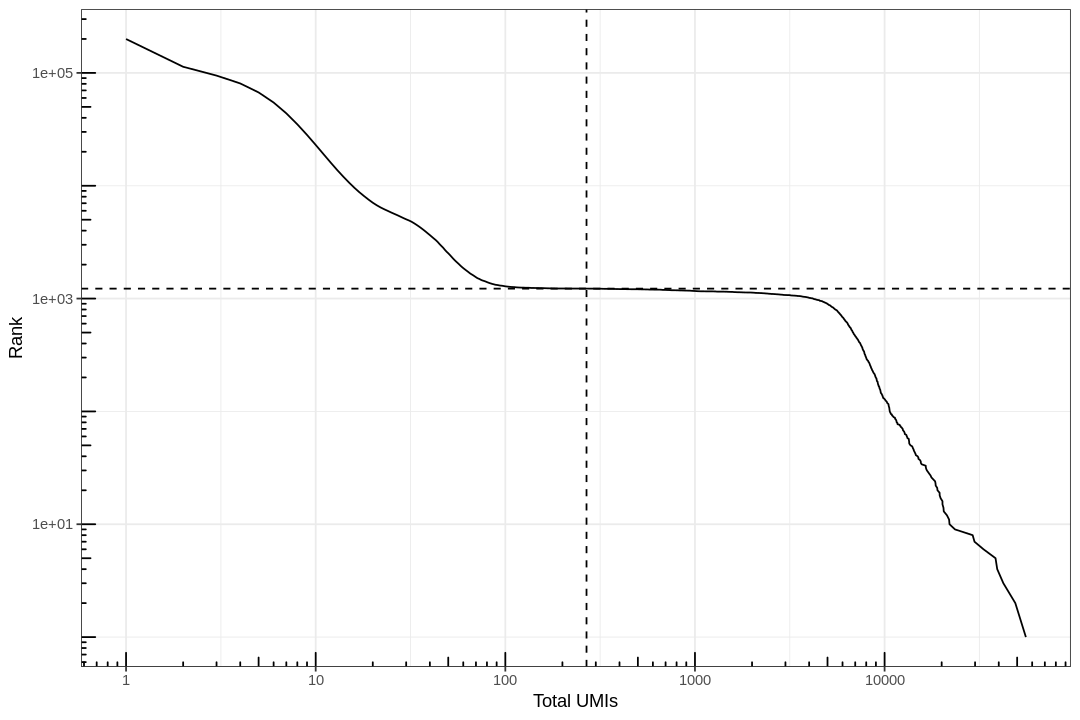

In [40]:
options(repr.plot.width=9, repr.plot.height=6)
knee_plot(bc_rank)

In [42]:
res_mat <- res_mat[, tot_counts > metadata(bc_rank)$inflection]
res_mat <- res_mat[Matrix::rowSums(res_mat) > 0,]
dim(res_mat)

[1] 21753  1225

### Visualizing count distributions

Percentage of transcripts from mitochondrially encoded genes

In [46]:
tr2g <- read_tsv("t2g.txt", col_names = c("transcript", "gene", "gene_symbol"), show_col_types = FALSE) %>%
  select(-transcript) %>%
  distinct()

In [24]:
# # Convert from Ensembl gene ID to gene symbol
# rownames(res_mat) <- tr2g$gene_symbol[match(rownames(res_mat), tr2g$gene)]

In [47]:
seu <- CreateSeuratObject(res_mat, min.cells = 3, min.features = 200)

In [50]:
ensembl <- biomaRt::useEnsembl(biomart = "ensembl", dataset = "hsapiens_gene_ensembl")  #* If service is down, try mirror = "useast"
mt_genes <- biomaRt::getBM(attributes = c('ensembl_gene_id', 'external_gene_name'), filters = 'chromosome_name', values = 'MT', mart = ensembl)

assay_gene_names <- rownames(seu[["RNA"]])
assay_gene_names_trimmed <- gsub("\\..*", "", assay_gene_names)
common_genes <- intersect(mt_genes$ensembl_gene_id, assay_gene_names_trimmed)
common_genes_with_version <- assay_gene_names[match(common_genes, assay_gene_names_trimmed)]
seu[["percent.mt"]] <- PercentageFeatureSet(seu, features = common_genes_with_version)

# seu[["percent.mt"]] <- PercentageFeatureSet(seu, pattern = "^mt-")

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


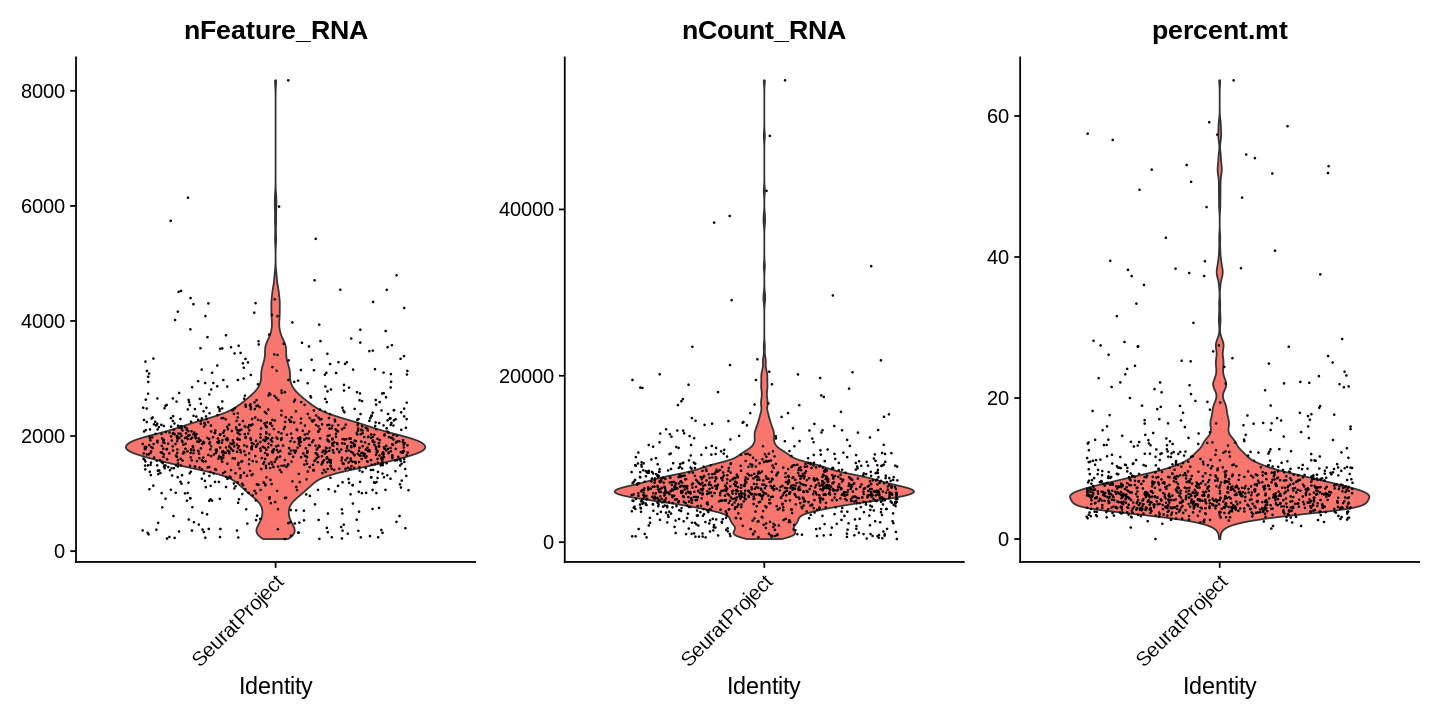

In [51]:
# Visualize QC metrics as a violin plot
options(repr.plot.width=12, repr.plot.height=6)
VlnPlot(seu, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, pt.size = 0.1)

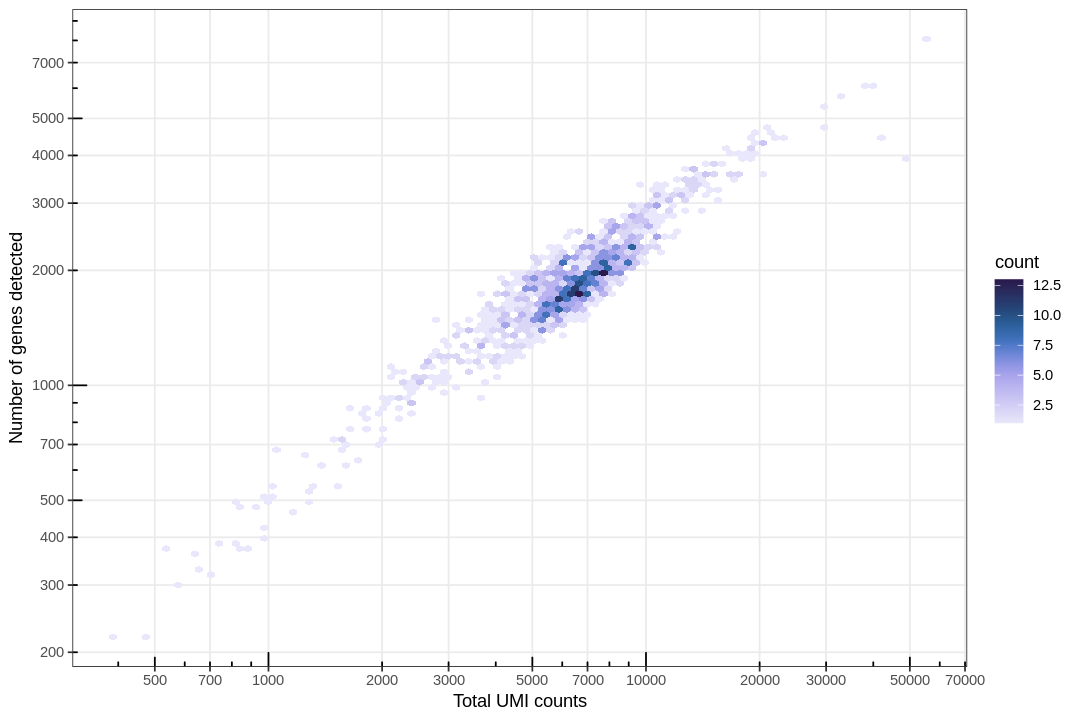

In [65]:
options(repr.plot.width=9, repr.plot.height=6)
ggplot(seu@meta.data, aes(nCount_RNA, nFeature_RNA)) +
  geom_hex(bins = 100) +
  scale_fill_scico(palette = "devon", direction = -1, end = 0.9) +
  scale_x_log10(breaks = breaks_log(12)) +
  scale_y_log10(breaks = breaks_log(12)) + annotation_logticks() +
  labs(x = "Total UMI counts", y = "Number of genes detected") +
  theme(panel.grid.minor = element_blank())

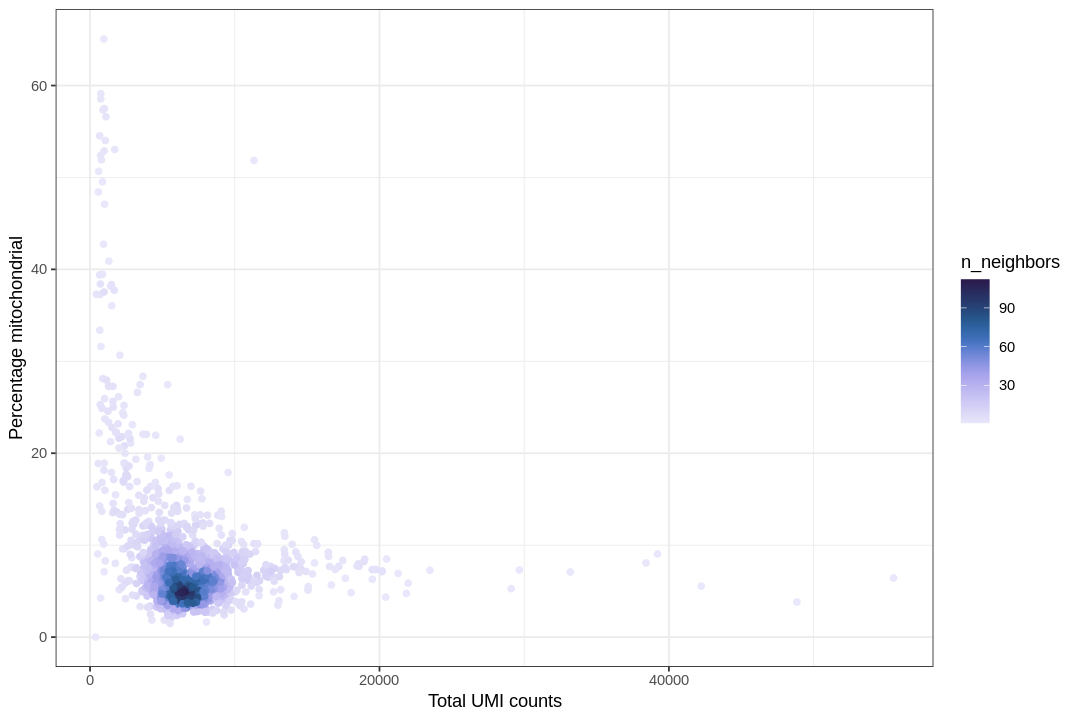

In [53]:
ggplot(seu@meta.data, aes(nCount_RNA, percent.mt)) +
  geom_pointdensity() +
  scale_color_scico(palette = "devon", direction = -1, end = 0.9) +
  labs(x = "Total UMI counts", y = "Percentage mitochondrial")

The color shows density of points, as the density is not apparent when many points are stacked on top of each other. Cells with high percentage of mitochondrially encoded transcripts are often removed in QC, as those are likely to be low quality cells. If a cell is lysed in sample preparation, transcripts in the mitochondria are less likely to be lost than transcripts in the cytoplasm due to the double membrane of the mitochondria, so cells that lysed tend to have a higher percentage of mitochondrially encoded transcripts.

We filter cells with more than 30% mitochondrial content based on the plot above.

In [54]:
seu <- subset(seu, subset = percent.mt < 30)

In [55]:
seu <- NormalizeData(seu) %>% ScaleData()

Normalizing layer: counts

Centering and scaling data matrix



## Analysis

### Identify highly variable genes

Finding variable features for layer counts

When using repel, set xnudge and ynudge to 0 for optimal results



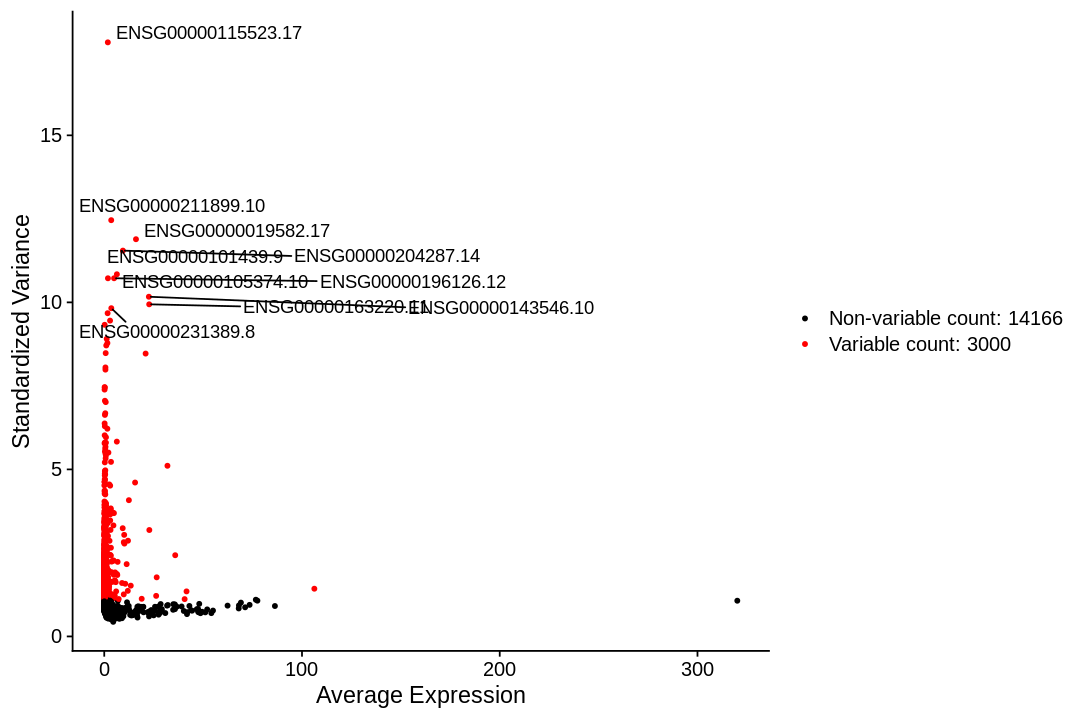

In [56]:
seu <- FindVariableFeatures(seu, nfeatures = 3000)
top10 <- head(VariableFeatures(seu), 10)
plot1 <- VariableFeaturePlot(seu, log = FALSE)
LabelPoints(plot = plot1, points = top10, repel = TRUE)

### PCA

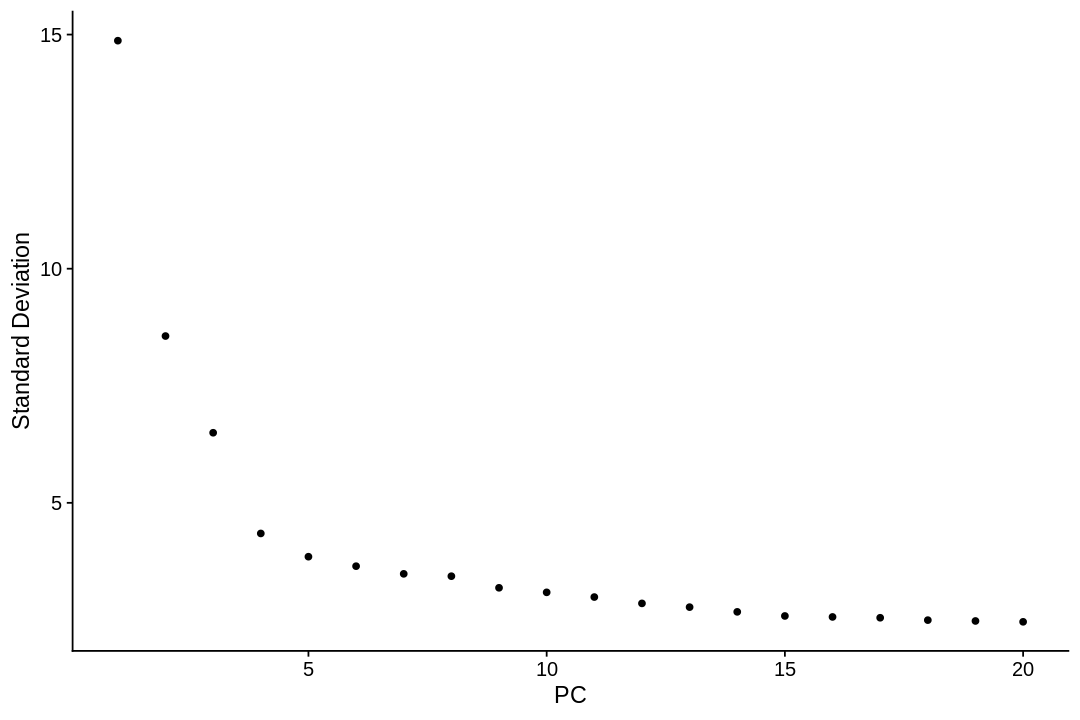

In [57]:
seu <- RunPCA(seu, verbose = FALSE, npcs = 20) # uses HVG by default
ElbowPlot(seu, ndims = 20)

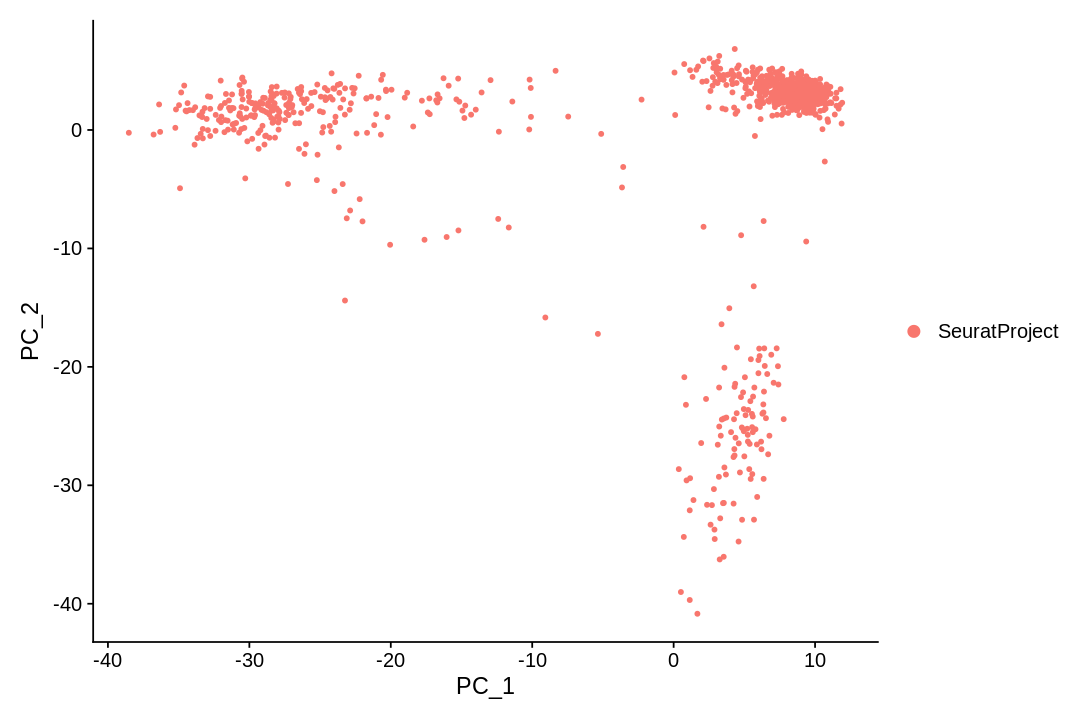

In [58]:
PCAPlot(seu)

### Clustering and visualization

There are many algorithms for clustering cells, and while they have been compared in detail in various benchmarks (see e.g., [Duo et al. 2018](https://f1000research.com/articles/7-1141/v2)), there is no univerally agreed upon method. Here we demonstrate clustering using [Louvain clustering](https://en.wikipedia.org/wiki/Louvain_modularity), which is a popular method for clustering single-cell RNA-seq data. The method was published in

- Blondel, Vincent D; Guillaume, Jean-Loup; Lambiotte, Renaud; Lefebvre, Etienne (9 October 2008). "Fast unfolding of communities in large networks". Journal of Statistical Mechanics: Theory and Experiment. 2008 (10): P10008.

In [59]:
seu <- FindNeighbors(seu, dims = 1:10)
seu <- FindClusters(seu)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1171
Number of edges: 37096

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8077
Number of communities: 10
Elapsed time: 0 seconds


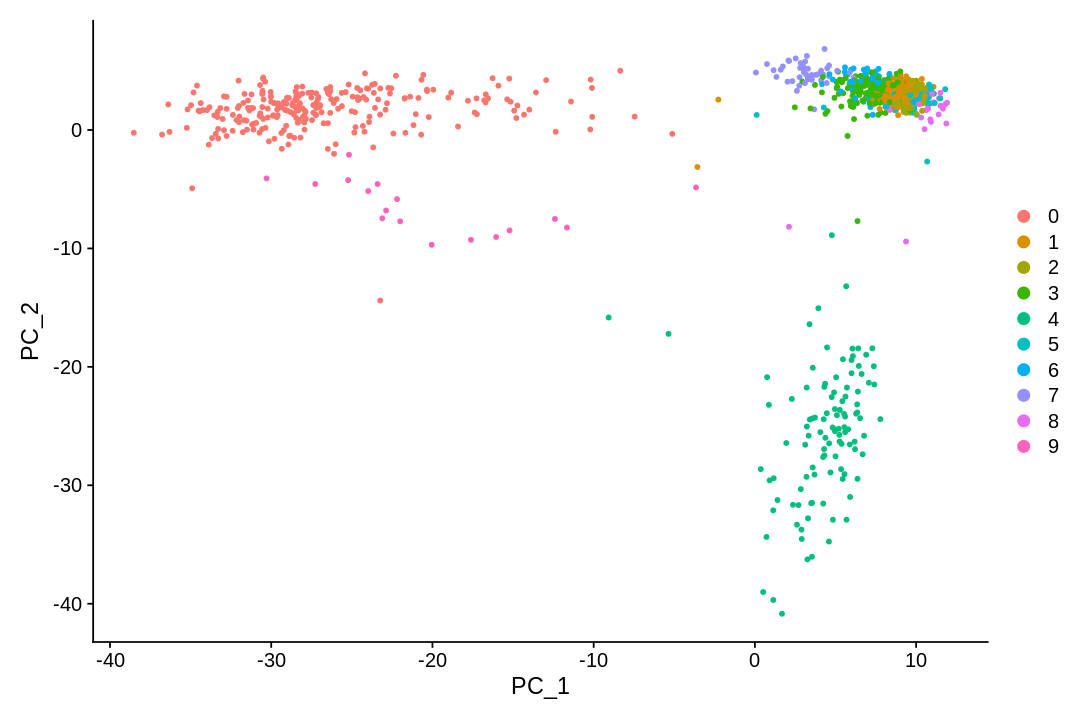

In [60]:
PCAPlot(seu)

### Visualization

Visualization of the clustered data can be performed through non-linear dimensionality reduction, often performed with UMAP and [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). Our group has demonstrated that both [UMAP](https://umap-learn.readthedocs.io/en/latest/) and t-SNE's non-linear natures make their interpretability highly limited. To read more, please see the following reference:

- Chari T, Pachter L. The Specious Art of Single-Cell Genomics [Internet]. Genomics; 2021 Aug [cited 2023 Sep 6]. Available from: http://biorxiv.org/lookup/doi/10.1101/2021.08.25.457696

However, for those still interested in these methodss, we demonstrate their use below.

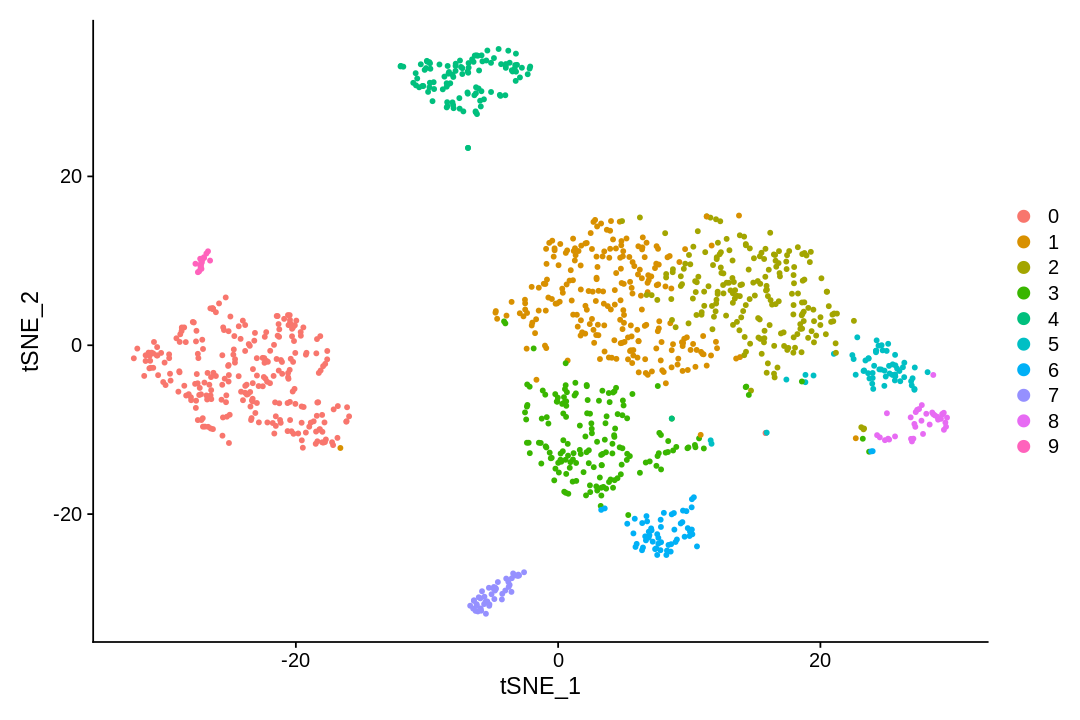

In [61]:
seu <- RunTSNE(seu, dims = 1:10)
TSNEPlot(seu)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


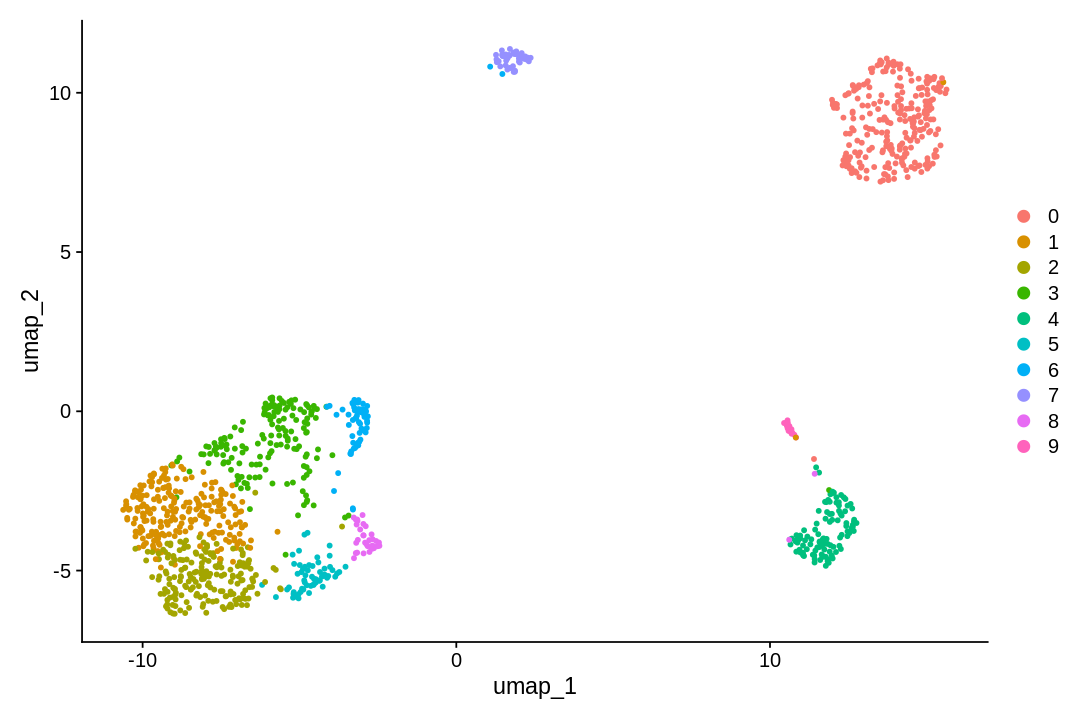

In [62]:
seu <- RunUMAP(seu, dims = 1:10, verbose = FALSE)
UMAPPlot(seu)

In [63]:
Sys.time() - start_time

Time difference of 2.814722 hours

Installing packages took about 26 minutes, which is a drawback of Rcpp. The QC and  analysis post-installation takes about 10 minutes from reads to results. This includes downloading the data, filtering, clustering and visualization.

**Feedback**: please report any issues, or submit pull requests for improvements, in the [Github repository where this notebook is located](https://github.com/pachterlab/kallistobustools/).